<a href="https://colab.research.google.com/github/eunsol-k/lets_eat_M/blob/SJ/Sample_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### CPU 사용 권장 dataset 전처리


In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import cv2
import numpy as np
import os


class ImageCrop():
    def __init__(self, config):
        '''
        open_path : original image open path
        save_path : crop image save path
        rotate_path : rotate image save path
        rotation_angle_circle : circle rotation angle
        rotation_angle_ellipse : ellipse rotation angle
        '''

        self.open_path = config['open_path']
        self.save_path = config['save_path']
        self.rotate_path = config['rotate_path']
        self.rotate_angle_circle = int(config['rotation_angle_circle'])
        self.rotate_angle_ellipse = int(config['rotation_angle_ellipse'])

        # Permission Error retry another path
        self.error_path_crop = './crop'
        self.error_path_rotation = './rotation'

        # dir index setting
        self.start_dir = config['start_dir_idx']
        self.end_dir = config['end_dir_idx']


    # square four point return
    # 객체의 바운딩 박스 찾기
    def ImageArea(self, input_image):
        rgba = cv2.medianBlur(input_image, 55)

        imgray = cv2.cvtColor(rgba, cv2.COLOR_BGRA2GRAY)
        contours, _ = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        contours_t = contours[0].transpose()

        right_point_x = np.max(contours_t[0])
        left_point_x = np.min(contours_t[0])
        right_point_y = np.max(contours_t[1])
        left_point_y = np.min(contours_t[1])

        return left_point_x, right_point_x, left_point_y, right_point_y


    # image crop
    def CropShape(self, input_image):
        left_x, right_x, left_y, right_y = self.ImageArea(input_image)
        crop_img = input_image[left_y:right_y, left_x:right_x]

        return crop_img


    # circle image rotation
    def rotate_image_circle(self, save_rotate_img, input_image):
        i = 0
        height, width, channel = input_image.shape

        while i < 360:
            f_path = save_rotate_img + '_' + str(i) + '.png'
            if not os.path.isfile(f_path):
                matrix = cv2.getRotationMatrix2D((width/2, height/2), i, 1)
                dst = cv2.warpAffine(input_image, matrix, (width, height))
                dst = self.CropShape(dst)

                cv2.imwrite(f_path, dst)
            else:
                print('rotate file exits : ', f_path)

            i = i + self.rotate_angle_circle


    # ellipse image rotation
    def rotate_image_ellipse(self, save_rotate_img, input_image):
        i = 0
        height, width, channel = input_image.shape

        while i < 360:
            if (i < 30) or (150 < i and i < 210) or (330 < i):
                f_path = save_rotate_img + '_' + str(i) + '.png'
                if not os.path.isfile(f_path):
                    matrix = cv2.getRotationMatrix2D((width/2, height/2), i, 1)
                    dst = cv2.warpAffine(input_image, matrix, (width, height))
                    dst = self.CropShape(dst)

                    cv2.imwrite(f_path, dst)
                else:
                    print('rotate file exits : ', f_path)

            i = i + self.rotate_angle_ellipse


    # image crop and rotation process
    def ImageProcess(self, shape):
        or_dirnames = os.listdir(self.open_path)

        if( int(self.start_dir) == -1 ):
            dirnames = or_dirnames
        else:
            dirnames = or_dirnames[int(self.start_dir):int(self.end_dir)]

        for dir in dirnames:
            try_num = 0
            # try
            try:
                # not exists folder in path, make folder
                if not os.path.exists(self.save_path + dir):
                    os.makedirs(self.save_path + '/' + dir)

                if not os.path.exists(self.rotate_path + dir):
                    os.makedirs(self.rotate_path + '/' + dir)
                try_num = 1

            except PermissionError:
                if not os.path.exists(self.error_path_crop + dir):
                    os.makedirs(self.error_path_crop + '/' + dir)
                    print("PermissionError except, image save path: ", self.error_path_crop)

                if not os.path.exists(self.error_path_rotation + dir):
                    os.makedirs(self.error_path_rotation + '/' + dir)
                    print("PermissionError except, image save path: ", self.error_path_rotation)
                try_num = 2

            except IOError as e:
                print("IOError except: ", e.errno)

            open_folder_path = os.path.join(self.open_path, dir)
            if try_num == 1:
                save_folder_path = os.path.join(self.save_path, dir)
                rotate_folder_path = os.path.join(self.rotate_path, dir)
            elif try_num == 2:
                save_folder_path = os.path.join(self.error_path_crop, dir)
                rotate_folder_path = os.path.join(self.error_path_rotation, dir)

            for path, folder, files in os.walk(open_folder_path):

                for file in files:
                    input_image = open_folder_path + '/' + file

                    print(input_image)

                    save_image = save_folder_path + '/' + file[0:len(file)-3] + 'png'
                    input_image = cv2.imread(input_image, cv2.IMREAD_UNCHANGED)

                    '''image crop'''
                    if not os.path.isfile(save_image):
                        crop_img = self.CropShape(input_image)
                        cv2.imwrite(save_image, crop_img)
                    else:
                        print( 'crop image file exits : ', save_image)

                    '''rotation'''
                    save_rotate_img = rotate_folder_path + '/' + file[0:len(file)-4]

                    if shape == 'circle':
                        self.rotate_image_circle(save_rotate_img, input_image)
                    elif shape == 'ellipse':
                        self.rotate_image_ellipse(save_rotate_img, input_image)


import cv2
import os
import errno


class ImageFiltering():
    def __init__(self, config):
        '''
        rotate_path : rotate image save path
        filter_path : filter image save path
        '''

        self.origin_folder_path = config['rotate_path']
        self.filter_folder_path = config['filter_path']

        # Permission Error retry another path
        self.error_path_filter = './filter'


    # make white background
    def white_Background(self, img):
        trans_mask = img[:,:,3]==0
        img[trans_mask] = [255, 255, 255, 255]
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

        return img


    # filter
    def max_con_CLAHE(self, img):
        # Converting image to LAB Color model
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Applying CLAHE to L-channel
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)

        # Merge the CLAHE enhanced L-channel with the a and b channel
        limg = cv2.merge((cl,a,b))

        # Converting image from LAB Color model to RGB model
        img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        return img

    # if image open fail, write log of fail image full path
    def tracelog(self, text):
        if text != "":
            text += "\n"
            f = open("tracelog.log","a")
            f.write(text)
            f.close()


    # filtering processing
    def imgFiltering(self):
        dirnames = os.listdir(self.origin_folder_path)

        for filename in dirnames:
            try_num = 0
            try:
                if not os.path.exists(self.filter_folder_path + filename):
                    os.makedirs(self.filter_folder_path + filename)
                try_num = 1

            except PermissionError:
                if not os.path.exists(self.error_path_filter + filename):
                    os.makedirs(self.error_path_filter + filename)
                    print("PermissionError except, image save path: ", self.error_path_filter)
                try_num = 2

            except IOError as e:
                print("IOError except: ", e.errno)

            origin_file_path = os.path.join(self.origin_folder_path, filename)
            if try_num == 1:
                filter_file_path = os.path.join(self.filter_folder_path, filename)
            elif try_num == 2:
                filter_file_path = os.path.join(self.error_path_filter, filename)

            for path, folder, files in os.walk(origin_file_path):

                for file in files:
                    print(filter_file_path+'/' + file)
                    print("origin path : ", origin_file_path +'/'+ file)

                    # file check
                    save_path = filter_file_path + '/' + file[0:len(file)-4] + '.jpg'
                    if os.path.isfile(save_path):
                        print("filter file exists : {}".format(save_path))
                        continue

                    img = cv2.imread(origin_file_path +'/'+ file, cv2.IMREAD_UNCHANGED)

                    # image check
                    if img is None:
                        self.tracelog(origin_file_path +'/'+ file)
                        print('typecheck ', type(img))
                        continue

                    ''' white background '''
                    img = self.white_Background(img)

                    ''' default filter '''
                    img = self.max_con_CLAHE(img)
                    img = self.max_con_CLAHE(img)

                    ''' filtering image save '''
                    cv2.imwrite(save_path , img)


import os
import shutil
from PIL import Image


class Separate():
    def __init__(self, config):
        '''
        filter_folder_path : filter image save path
        folder_save_path : traing/validation/traing separate image folder save path
        '''

        self.open_path = config['save_path']
        self.save_path = config['separate_path']


    def FolderList(self):
        type_list = []
        folder_list = []

        for (path, folder, files) in os.walk(self.open_path):
            type_list.append(path)
            folder_list.append(folder)

        folders = ','.join(folder_list[0])
        folder_list = folders.split(',')
        type_list.pop(0)

        return folder_list


    def makeSubfolder(self, new_dir_path, folder_list):
        for num in range(len(folder_list)):
            os.makedirs(new_dir_path + folder_list[num])


    def ml_directory(self, folder_list):
        if not os.path.exists(self.save_path + 'training'):
            os.makedirs(self.save_path + 'training')
            self.makeSubfolder(self.save_path + 'training/', folder_list)

        if not os.path.exists(self.save_path + 'testing'):
            os.makedirs(self.save_path + 'testing')
            self.makeSubfolder(self.save_path + 'testing/', folder_list)

        if not os.path.exists(self.save_path + 'validation'):
            os.makedirs(self.save_path + 'validation')
            self.makeSubfolder(self.save_path + 'validation/', folder_list)


    def separate(self, dir_path, x):
        dirname = self.open_path + x
        filenames = os.listdir(dirname)
        i = 0
        for filename in filenames:
            full_filename = os.path.join(dirname, filename)

            with Image.open(full_filename) as image:
                if i % 10 < 7:
                    training_directory = os.path.join(dir_path + 'training/', x)
                    shutil.copyfile(full_filename, os.path.join(training_directory, filename))

                elif i % 10 >= 7 and i % 10 < 8:
                    validation_directory = os.path.join(dir_path + 'testing/', x)
                    shutil.copyfile(full_filename, os.path.join(validation_directory, filename))

                else:
                    testing_directory = os.path.join(dir_path + 'validation/', x)
                    shutil.copyfile(full_filename, os.path.join(testing_directory, filename))
            i = i + 1


    def separateProcess(self):
        folder_list = self.FolderList()
        self.ml_directory(folder_list)

        for x in folder_list:
            self.separate(self.save_path, x)

import configparser
import sys


class PreprocessingMain():
    def __init__(self):
        self.config_file = '/content/gdrive/MyDrive/Dataset/sample_dataset/preprocessing.ini'

    def main(self, argv):
        # ex) python3 PreProcessing.py circle config.ini
        self.config_file = argv[1]

        shape = argv[0]

        config = configparser.ConfigParser()
        config.read(self.config_file, encoding='UTF-8')

        self.ImgCrop = ImageCrop(config['img_processing'])
        self.ImgFilter = ImageFiltering(config['img_processing'])
        self.Separate = Separate(config['img_processing'])


        """ Image Crop """
        self.ImgCrop.ImageProcess(shape)

        """ Image Filtering """
        self.ImgFilter.imgFiltering()

        """ Image Separte"""
        self.Separate.separateProcess()

        print('####### finish #######')


if __name__ == '__main__':
    main_class = PreprocessingMain()
    main_class.main(['none', '/content/gdrive/MyDrive/Dataset/sample_dataset/preprocessing.ini'])



/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_009.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_010.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_004.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_006.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_007.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_001.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_017.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_008.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_013.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_003.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_002.png
/content/gdrive/MyDrive/Dataset/sample_dataset/image/201207061/201207061_005.png
/content/gdrive/MyDrive/Data

#### GPU 사용 권장 Train


In [ ]:
!pip install pkbar
!pip install torchbearer

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')


[ Model ]

PillModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

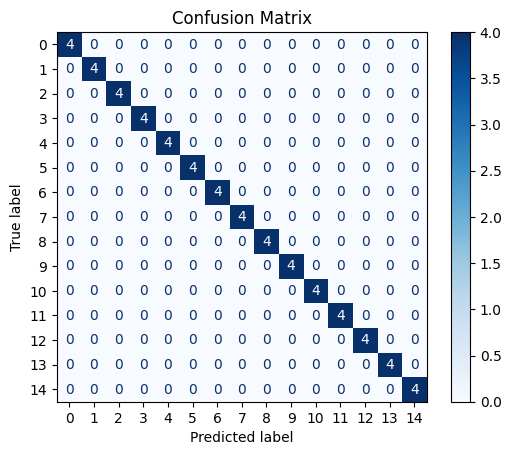

In [7]:
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# image file truncated error prevention
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

class ResizeAndPad(object):
    def __init__(self, desired_size):
        self.desired_size = desired_size

    def __call__(self, image):
        desired_width, desired_height = self.desired_size
        original_width, original_height = image.size

        # 비율 유지하여 리사이즈
        ratio = min(desired_width / original_width, desired_height / original_height)
        new_width = int(original_width * ratio)
        new_height = int(original_height * ratio)
        resized_image = image.resize((new_width, new_height), Image.LANCZOS)

        # 새 이미지 생성 및 패딩
        new_image = Image.new("RGB", (desired_width, desired_height))
        pad_left = (desired_width - new_width) // 2
        pad_top = (desired_height - new_height) // 2
        new_image.paste(resized_image, (pad_left, pad_top))

        return new_image

class PyTorchData():
    def __init__(self, _dataType, config):
        '''
        input_dim : image size
        data_path : training data path
        batch_size : batch size
        '''

        if _dataType == "data":
            self.m_DataDim = int(config['input_dim'])
        elif _dataType == "image":
            self.m_ImageDim = int(config['input_dim'])
            self.m_DataPath = config['data_path']
            self.m_BatchSize = int(config['batch_size'])


    def ImageTrain(self):
        # 이미지를 200x200으로 변환
        transDatagen = transforms.Compose([ResizeAndPad((self.m_ImageDim, self.m_ImageDim)),
                                           transforms.ToTensor()])

        trainPath = self.m_DataPath + '/training'
        trainFolder = torchvision.datasets.ImageFolder(root = trainPath,
                                                       transform = transDatagen)

        trainLoader = DataLoader(trainFolder,
                                batch_size = self.m_BatchSize,
                                shuffle = True)

        print("Train Class [", trainLoader.dataset.class_to_idx, "]")
        print("Train Numbers [", len(trainLoader.dataset.imgs), "]")
        print("Train Batch Size [", trainLoader.batch_size, "]")

        return trainLoader


    def ImageValidation(self):
        transDatagen = transforms.Compose([ResizeAndPad((self.m_ImageDim, self.m_ImageDim)),
                                           transforms.ToTensor()])

        validationPath = self.m_DataPath + '/validation'
        validationSet = torchvision.datasets.ImageFolder(root = validationPath,
                                                         transform = transDatagen)

        validationLoader = DataLoader(validationSet,
                                      batch_size = self.m_BatchSize,
                                      shuffle = False)

        print("Validation Class [", validationLoader.dataset.class_to_idx, "]")
        print("Validation Numbers [", len(validationLoader.dataset.imgs),"]")
        print("Validation Batch Size [", validationLoader.batch_size,"]")

        return validationLoader


    def ImageTest(self):
        transDatagen = transforms.Compose([ResizeAndPad((self.m_ImageDim, self.m_ImageDim)),
                                           transforms.ToTensor()])

        testDirectory = self.m_DataPath + '/testing'
        testSet = torchvision.datasets.ImageFolder(root = testDirectory,
                                                   transform = transDatagen)

        testLoader = DataLoader(testSet,
                                batch_size = self.m_BatchSize,
                                shuffle = False)

        print("Test Class [", testLoader.dataset.class_to_idx, "]")
        print("Test Numbers [", len(testLoader.dataset.imgs), "]")
        print("Test Batch Size [", testLoader.batch_size,"]")

        return testLoader


import torch
import torch.nn as nn
import pkbar
import numpy as np
import random
import torchvision.models as models


# seed fix
SEED = 3
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.manual_seed(SEED)


class PillModel(nn.Module):
    # bulid cnn model
    def __init__(self, config):
        super(PillModel, self).__init__()
        '''
        ClassNum : class number
        '''

        self.m_ClassNum = int(config['class_num'])
        # ResNet 모델 초기화
        self.resnet = models.resnet18(pretrained=True)

        # 마지막 fully connected layer의 출력 크기를 클래스 수에 맞게 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, self.m_ClassNum)


    def forward(self, x):
        # ResNet 모델의 forward pass 수행
        x = self.resnet(x)
        return x


import torch.optim as optim
import torchbearer
from torchbearer import Trial
import datetime


class MakeModel():
    def __init__(self,config):
        '''
        learning_rate : learning rate
        epochs : epoch
        save_path : save path
        model_name : model save name
        '''

        self._epoch = int(config['epochs'])
        self._lr = float(config['learning_rate'])
        self._savePath = config['save_path']
        self._modelName = config['model_name']


    def SaveModel(self, _model, optimizer, _trainData, trainLoss):
        nowdate = datetime.datetime.now().strftime('%y%m%d_%H')
        ret = 0
        try:
            torch.save({'model_state_dict': _model.state_dict(),
                        'epoch': self._epoch,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': trainLoss,
                        'label_name':_trainData.dataset.classes},
                        self._savePath + self._modelName + '_PyTorchModel.pt')
            print("model saved [", self._savePath +  self._modelName + "_PyTorchModel.pt ]")

        except PermissionError:
                torch.save(_model, './' + nowdate + '_' + self._modelName + '_PyTorchModel.pt')
                print('model saved [ ./' + nowdate + '_' + self._modelName + '_PyTorchModel.pt ]')

        except IOError as e:
            print("IOError except: ", e.errno)
            ret = 1

        return ret


    def Training(self, _device, _model, _trainData, _valData):
        _model.train()

        optimizer = optim.Adam(_model.parameters(), lr = self._lr)
        criterion = torch.nn.CrossEntropyLoss()
        bestValLoss = float('inf')

        for epoch in range(self._epoch):
            trainLoss = 0.0
            trainSize = 0.0
            trainCorrect = 0.0

            print("Epoch {}/{}".format(epoch + 1, self._epoch))
            progress = pkbar.Kbar(target=len(_trainData), width = 25)

            # train
            for batchIdx, data in enumerate(_trainData):
                images, labels = data
                images, labels = images.to(_device), labels.to(_device)

                optimizer.zero_grad()
                outputs = _model(images)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                trainLoss = loss.item()

                _, predicted = outputs.max(1)
                trainSize += labels.shape[0]
                trainCorrect += predicted.eq(labels.view_as(predicted)).sum().item()
                trainAccuracy = 100 * trainCorrect / trainSize

                progress.update(batchIdx, values = [("loss: ", trainLoss), ("acc: ", trainAccuracy)])

                del loss
                del outputs

            # validation
            with torch.no_grad():
                valLoss = 0.0
                valSize = 0.0
                valCorrect = 0.0

                for batchIdx, data in enumerate(_valData):
                    images, labels = data
                    images, labels = images.to(_device), labels.to(_device)

                    outputs = _model(images)
                    valLoss = criterion(outputs, labels).item()

                    _, predicted = outputs.max(1)
                    valSize += labels.shape[0]

                    valCorrect += predicted.eq(labels.view_as(predicted)).sum().item()
                    valAccuracy = 100 * valCorrect / valSize

                progress.add(1, values=[("val loss", valLoss), ("val acc", valAccuracy)])

            # if best loss value, save model
            if valLoss < bestValLoss:
                bestValLoss = valLoss
                ret = self.SaveModel(_model, optimizer, _trainData, trainLoss)

        return ret


    # test set model test
    def Testing(self, _device, _model, _testData):
        _model.eval()
        criterion = torch.nn.CrossEntropyLoss()

        testLoss = 0.0
        testSize = 0.0
        testCorrect = 0.0
        all_labels = []
        all_predictions = []

        progress = pkbar.Kbar(target=len(_testData), width=25)

        with torch.no_grad():
            for batchIdx, data in enumerate(_testData):
                images, labels = data
                images, labels = images.to(_device), labels.to(_device)
                outputs = _model(images)

                loss = criterion(outputs, labels).item()
                testLoss += loss

                _, predicted = outputs.data.max(1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                testSize += labels.shape[0]
                testCorrect += predicted.eq(labels.view_as(predicted)).sum().item()
                accuracy = 100 * testCorrect / testSize

                progress.update(batchIdx, values=[("test loss: ", testLoss / (batchIdx + 1)), ("test acc: ", accuracy)])

            testLoss /= len(_testData.dataset)
        progress.add(1)

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()




import torch
import configparser
import torch.nn as nn


class PyTorchMain():
    def __init__(self):
        config = configparser.ConfigParser()
        config.read('/content/gdrive/MyDrive/Dataset/sample_dataset/modeling_config.ini', encoding='UTF-8')

        self.m_Device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.m_cPytorchModel = PillModel(config['PT_model_info'])

        self.m_cPytorchData = PyTorchData("image", config['PT_model_info'])

        self.m_cMakeModel = MakeModel(config['PT_model_info'])


    def main(self):
        print("\n[ Model ]\n")
        model = self.m_cPytorchModel.to(self.m_Device)
        print(model)

        # load dataset
        print("\n[ Data ]\n")
        trainData = self.m_cPytorchData.ImageTrain()
        valData = self.m_cPytorchData.ImageValidation()
        testData = self.m_cPytorchData.ImageTest()

        # training
        print("\n[ Training ]\n")
        ret = self.m_cMakeModel.Training(_device = self.m_Device,
                                         _model = model,
                                         _trainData = trainData,
                                         _valData = valData)
        if ret == 0 or ret == 1:
            # testing
            print("\n[ Testing ]\n")
            self.m_cMakeModel.Testing(_device = self.m_Device,
                                      _model = model,
                                      _testData = testData)


if __name__ == '__main__':
    mainClass = PyTorchMain()
    mainClass.main()


In [ ]:
# 리사이즈 시각화
import matplotlib.pyplot as plt
import configparser
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets

class ResizeAndPad(object):
    def __init__(self, desired_size):
        self.desired_size = desired_size

    def __call__(self, image):
        desired_width, desired_height = self.desired_size
        original_width, original_height = image.size

        # 비율 유지하여 리사이즈
        ratio = min(desired_width / original_width, desired_height / original_height)
        new_width = int(original_width * ratio)
        new_height = int(original_height * ratio)
        resized_image = image.resize((new_width, new_height), Image.LANCZOS)

        # 새 이미지 생성 및 패딩
        new_image = Image.new("RGB", (desired_width, desired_height))
        pad_left = (desired_width - new_width) // 2
        pad_top = (desired_height - new_height) // 2
        new_image.paste(resized_image, (pad_left, pad_top))

        return new_image

class PyTorchData():
    def __init__(self, _dataType, config):

        if _dataType == "data":
            self.m_DataDim = int(config['input_dim'])
        elif _dataType == "image":
            self.m_ImageDim = int(config['input_dim'])
            self.m_DataPath = '/content/gdrive/MyDrive/Dataset/sample_dataset/test.jpg'
            self.m_BatchSize = int(config['batch_size'])

    def ImageTrain(self):
        # 이미지를 dimxdim으로 변환
        transDatagen = transforms.Compose([ResizeAndPad((self.m_ImageDim, self.m_ImageDim)),
                                           transforms.ToTensor()])

        trainPath = self.m_DataPath + '/training'
        trainFolder = torchvision.datasets.ImageFolder(root=trainPath, transform=transDatagen)

        trainLoader = DataLoader(trainFolder, batch_size=self.m_BatchSize, shuffle=True)

        return trainLoader

    def show_images(self, num_images):
        trainLoader = self.ImageTrain()
        data_iter = iter(trainLoader)
        images, _ = next(data_iter)

        # 이미지를 보여줌
        fig, axes = plt.subplots(1, num_images, figsize=(12, 12))
        for i in range(num_images):
            image = images[i].permute(1, 2, 0).numpy()
            axes[i].imshow(image)
            axes[i].axis('off')
        plt.show()

# 예제 사용법
config = configparser.ConfigParser()
config.read('/content/gdrive/MyDrive/Dataset/sample_dataset/modeling_config.ini', encoding='UTF-8')

data = PyTorchData('image', config['PT_model_info'])
data.show_images(1)


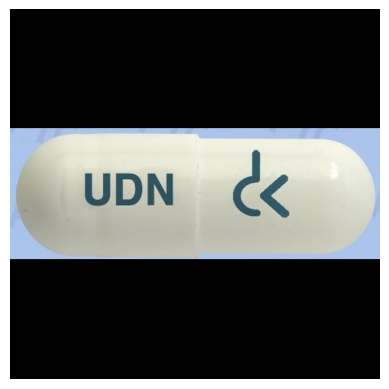

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

class ResizeAndPad(object):
    def __init__(self, desired_size):
        self.desired_size = desired_size

    def __call__(self, image):
        desired_width, desired_height = self.desired_size
        original_width, original_height = image.size

        # 비율 유지하여 리사이즈
        ratio = min(desired_width / original_width, desired_height / original_height)
        new_width = int(original_width * ratio)
        new_height = int(original_height * ratio)
        resized_image = image.resize((new_width, new_height), Image.LANCZOS)

        # 새 이미지 생성 및 패딩
        new_image = Image.new("RGB", (desired_width, desired_height))
        pad_left = (desired_width - new_width) // 2
        pad_top = (desired_height - new_height) // 2
        new_image.paste(resized_image, (pad_left, pad_top))

        return new_image

def resize_and_show(image_path, desired_size):
    # 이미지 불러오기
    image = Image.open(image_path)

    # ResizeAndPad 변환 적용
    transformer = ResizeAndPad(desired_size)
    transformed_image = transformer(image)

    # 변환된 이미지 출력
    plt.imshow(transformed_image)
    plt.axis('off')
    plt.show()

# 예제 사용법
image_path = '/content/gdrive/MyDrive/Dataset/sample_dataset/test2.jpg'
desired_size = (500, 500)  # 원하는 크기로 설정
resize_and_show(image_path, desired_size)


#### GPU 사용 권장 Predict


In [21]:
import torch
import torch.nn as nn
import numpy as np
import random
from PIL import Image
import torchvision.transforms as transforms
import cv2
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

class ResizeAndPad(object):
    def __init__(self, desired_size):
        self.desired_size = desired_size

    def __call__(self, image):
        desired_width, desired_height = self.desired_size
        original_width, original_height = image.size

        # 비율 유지하여 리사이즈
        ratio = min(desired_width / original_width, desired_height / original_height)
        new_width = int(original_width * ratio)
        new_height = int(original_height * ratio)
        resized_image = image.resize((new_width, new_height), Image.LANCZOS)

        # 새 이미지 생성 및 패딩
        new_image = Image.new("RGB", (desired_width, desired_height))
        pad_left = (desired_width - new_width) // 2
        pad_top = (desired_height - new_height) // 2
        new_image.paste(resized_image, (pad_left, pad_top))

        return new_image

class PillModel(nn.Module):
    # bulid cnn model
    def __init__(self):
        super(PillModel, self).__init__()

        self.m_ClassNum = 15
        # ResNet 모델 초기화
        self.resnet = models.resnet18(pretrained=True)

        # 마지막 fully connected layer의 출력 크기를 클래스 수에 맞게 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, self.m_ClassNum)


    def forward(self, x):
        # ResNet 모델의 forward pass 수행
        x = self.resnet(x)
        return x

# 이미지 전처리 함수
def preprocess_image(image_path):
    transform = transforms.Compose([ResizeAndPad((500, 500)),
                                           transforms.ToTensor()])
    image = Image.open(image_path).convert("RGB")  # 이미지를 RGB 형식으로 열기
    image = transform(image).unsqueeze(0)         # 배치 차원 추가
    return image

# 모델 로드
model = PillModel()
checkpoint = torch.load("/content/gdrive/MyDrive/Dataset/sample_dataset/sample_PyTorchModel.pt", map_location=torch.device('cpu'))  # 모델 파일 로드
model.load_state_dict(checkpoint['model_state_dict'])  # 모델의 상태 사전 로드
model.eval()

# 클래스 이름 목록
class_names = checkpoint['label_name']

# 이미지 분류 함수
def classify_image(image, model, class_names):


    # 모델 추론
    with torch.no_grad():
        output = model(image)

    # 확률로 변환
    probabilities = torch.softmax(output, dim=1)

    print(probabilities)
    # 클래스 이름과 해당 확률 출력
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {probabilities[0][i].item():.2f}")

    # 클래스 예측
    _, predicted_class = torch.max(probabilities, 1)

    # 클래스 이름 가져오기
    class_name = class_names[predicted_class.item()]

    return class_name, probabilities[0][predicted_class].item()

# 이미지 분류
image_path = "/content/gdrive/MyDrive/Dataset/sample_dataset/test.jpg"  # 이미지 파일 경로

# 이미지 전처리
image = preprocess_image(image_path)

predicted_class, confidence = classify_image(image, model, class_names)

# 결과 출력
print("예측된 클래스:", predicted_class)
print("확신도:", confidence)

tensor([[0.0143, 0.0180, 0.4831, 0.0102, 0.0018, 0.0789, 0.0092, 0.2138, 0.0049,
         0.0068, 0.0191, 0.0438, 0.0223, 0.0056, 0.0682]])
199201045: 0.01
199300225: 0.02
199302671: 0.48
199400095: 0.01
199400392: 0.00
200611304: 0.08
200700455: 0.01
200701917: 0.21
201002277: 0.00
201207061: 0.01
201504332: 0.02
201505091: 0.04
201706572: 0.02
201706734: 0.01
201706750: 0.07
예측된 클래스: 199302671
확신도: 0.4830950200557709


#### 빈 셀
